In [2]:
import numpy as np
from numpy import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalMaxPool1D, GlobalMaxPool2D, Conv2D, MaxPooling2D,Activation,Flatten
from tensorflow.keras.models import Sequential

#### We start by importing the __MNIST__ dataset and reshaping them.

In [3]:
(X, y), (X_test, y_test) = mnist.load_data()
print('X_train: ' + str(X.shape))
print('Y_train: ' + str(y.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))
#pyplot.imshow(X[i], cmap=pyplot.get_cmap('gray')) gives image

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [4]:
X_train = pd.DataFrame(X.reshape(-1, 784))
X_test = pd.DataFrame(X_test.reshape(-1, 784))
y_train = pd.DataFrame(y)[0]
y_test = pd.DataFrame(y_test)[0]
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))
X_train,X_test = X_train / 255.0, X_test / 255.0

X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


We write the functions for creation of __ANN__ and other useful ones

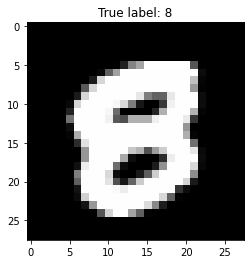

In [4]:
def create_ann(op=10):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(features,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(op, activation='softmax')
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model


def confidence(model, ip, label=None):
    v= ip.values
    v=v.reshape(-1,1)
    if not label:
      a=list(model.predict(v.T)[0])
      return a.index(max(a)),max(a)      
    return model.predict(v.T)[0][label]

def confidence_distribution(model, ip,ind = 0,op=10):
    try:
        model = model.model
    except:
        pass
    ip=ip.iloc[ind,:]
    v= ip.values
    v=v.reshape(-1,1)
    l=model.predict(v.T)[0]
    plt.bar([i for i in range(op)],l)
    plt.show()
    
    
def show_mistake(model,df,i=None,y_test = y_test):
    try:
        model = model.model
    except:
        pass
    p_test = model.predict(df).argmax(axis=1)
    wrong_idx = np.where(p_test != y_test)[0]
    if i is None:
        i = np.random.choice(wrong_idx)
    display(df, y_test, i)
    print("Predicted: ",p_test[i])
    return i
    
    
def display(df, ydf, index):
    dd = df.iloc[index,:].to_numpy() *255
    try:
        if not ydf:
            plt.imshow(dd.reshape(28,28), cmap='gray')
    except:
        plt.title("True label: %s" % (ydf[index]))
        plt.imshow(dd.reshape(28,28), cmap='gray')

def threshold(df,t_val):
    out = df.copy()
    for i in range(df.shape[0]):
        out.iloc[i,:] = df.iloc[i,:].apply(lambda x: 0 if x<t_val else 1)
    return out

def model_stats(model):
    a_float = model.history['val_accuracy'][-1]*100
    plt.plot(model.history['accuracy'], label='train_acc')
    plt.plot(model.history['val_accuracy'], label='val_acc')
    plt.title("{:.2f}".format(a_float)+"% accuracy")
    plt.legend()
    
def load(m):
    try:
        return tf.keras.models.load_model(m)
    except OSError:
        print(str(m)+" not found")

              

def noise_analysis(model, conf_th = 0.75, noise_n = 100):
    noise = pd.DataFrame(np.random.rand(noise_n, 784))
    nums=[]
    cnum=[]
    try:
        model = model.model
    except:
        pass
    for i in range(noise.shape[0]):
        num,conf = confidence(model, noise.iloc[i,:])
        nums.append(num)
        if conf>conf_th:
            cnum.append(num)
    plt.hist(nums)
    plt.xticks(range(11))
    plt.title("Distribution of "+str(len(nums))+" noise data sets and their predicted labels")
    plt.show()
    plt.hist(cnum)
    plt.xticks(range(11))
    plt.title("Distribution of "+str(len(cnum))+"/"+str(len(nums))+" noise data sets that show a confidence above "+str(conf_th*100)+"%")
    plt.show()


def shuff_together(df1,df2):
    joined = pd.concat([df1,df2], axis=1)
    joined = joined.iloc[np.random.permutation(len(joined))].reset_index(drop=True)
    return joined.iloc[:,:-1],joined.iloc[:,-1]

def model_predictions(model,df,y_test=y_test):
    try:
        model = model.model
    except:
        pass
    preds = model.predict(df)
    l=[list(preds[i]).index(max(preds[i])) for i in range(preds.shape[0])]
    plt.hist(y_test, label=['Actual values'])
    plt.hist(l, label=['Predicted values'])
    plt.legend(loc='upper right')
    plt.title("Distribution of model predicted values vs actual labels")
    plt.show()
    return l

display(X_test, y_test, 8097)

Standard MNIST __training__ using ANN

INFO:tensorflow:Assets written to: ann/assets


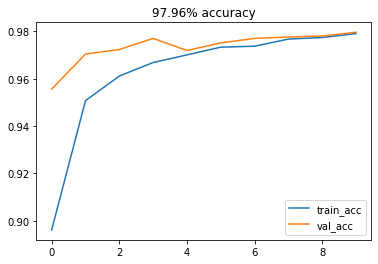

In [5]:
features = X_train.shape[1]

model =  create_ann()
ann = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,verbose=0)
ann.model.save("ann")
model_stats(ann)
#load("ann")

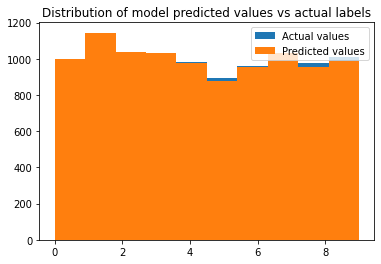

In [6]:
_ = model_predictions(ann,X_test)

#### We look at one of the wrongly labelled test cases as well as its probability distribution prediction by the model.

Predicted:  6


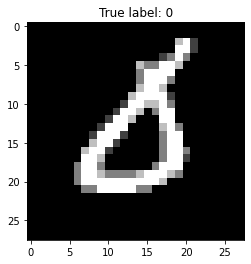

In [ ]:
#Shows random mistake each time this cell is executed
i=show_mistake(ann,X_test)

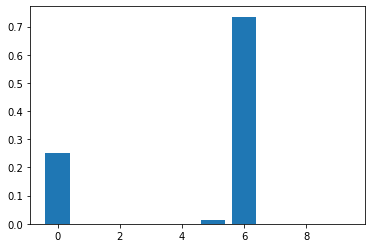

In [ ]:
confidence_distribution(ann, X_test,i)

#### Intelligence of a model is how well it learns to do its job correctly given a dataset. It is inversely proportional to the size of the training set.
Here we will limit the training set to $maxrows$

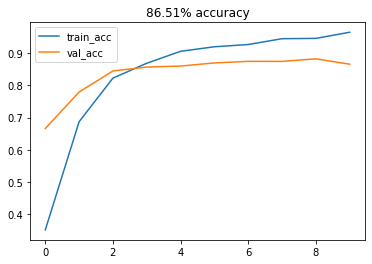

In [ ]:
#INTELLIGENCE

model = create_ann()
maxrows = 1000
r = model.fit(X_train.iloc[:maxrows,:], y_train.iloc[:maxrows,], validation_data=(X_test, y_test), epochs=10,verbose=0)
model_stats(r)

#### Trying pre processing of data using a threshold value. Below, everything above 90% of the pixel value is changed to 100% while other pixels are at 0%

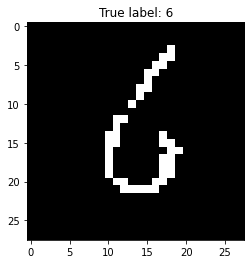

In [ ]:
X_train_50 = threshold(X_train,0.9)
X_test_50 = threshold(X_test,0.9)
display(X_test_50, y_test, 50)

#### This does not seem to increase the intelligence when we test on normal test as well as pre processed test data

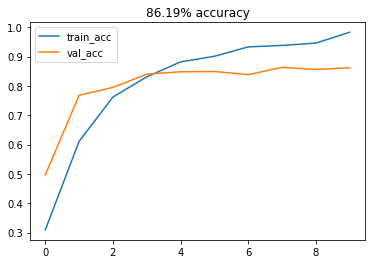

In [ ]:
model = create_ann()
r = model.fit(X_train_50.iloc[:maxrows,:], y_train.iloc[:maxrows,], validation_data=(X_test, y_test), epochs=10,verbose=0)
model_stats(r)

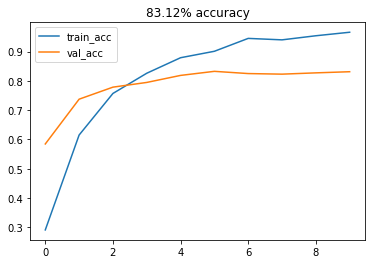

In [ ]:
model = create_ann()
r = model.fit(X_train_50.iloc[:maxrows,:], y_train.iloc[:maxrows,], validation_data=(X_test_50, y_test), epochs=10,verbose=0)
model_stats(r)

#### We will create <font color=blue>noisy</font> test data

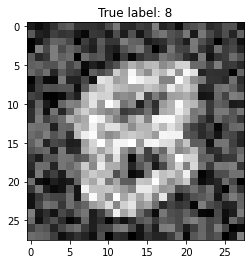

In [ ]:
X_test_noisy = X_test.apply(lambda x: x-random.rand())
display(X_test_noisy, y_test, 8097)

Trying to see if this model __ANN__ works on this as a test of versatility and robustness

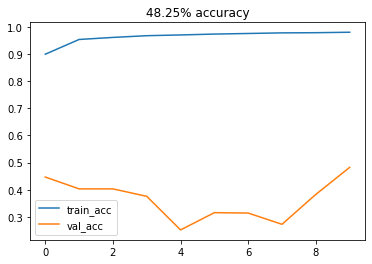

In [ ]:
model = create_ann()
ann = model.fit(X_train, y_train, validation_data=(X_test_noisy, y_test), epochs=10,verbose=0)
#ann.model.save("ann")
model_stats(ann)

We will try to __train with noisy data__ and see

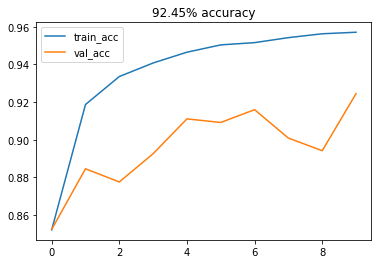

In [ ]:
X_train_noisy = X_train.apply(lambda x: x-random.rand())
model = create_ann()
ann_noisy = model.fit(X_train_noisy, y_train, validation_data=(X_test_noisy, y_test), epochs=10,verbose=0)
model_stats(ann_noisy)

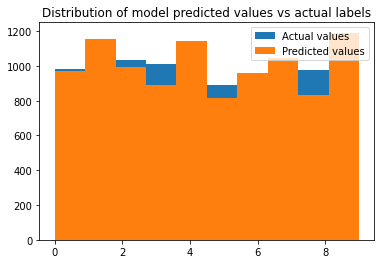

In [ ]:
_ = model_predictions(ann_noisy,X_test_noisy)

Predicted:  2


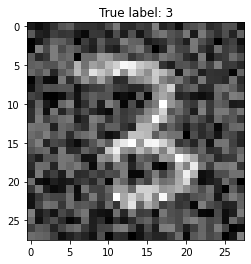

In [ ]:
i=show_mistake(ann_noisy,X_test_noisy)

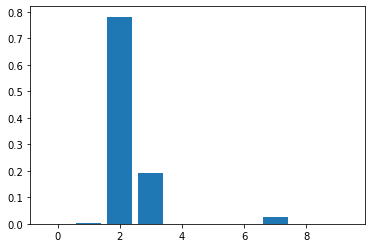

In [ ]:
confidence_distribution(ann_noisy, X_test_noisy,i)

#### The model trained with noisy data (ann_noisy) seems to give much better accuracy for noisy test data and as good accuracy for the normal test data shown below making it more versatile

INFO:tensorflow:Assets written to: ann_noisy\assets


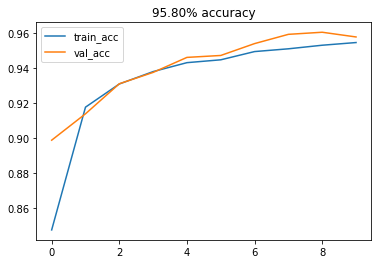

In [ ]:
model = create_ann()
ann_noisy = model.fit(X_train_noisy, y_train, validation_data=(X_test, y_test), epochs=10,verbose=0)
model_stats(ann_noisy)
ann_noisy.model.save("ann_noisy")

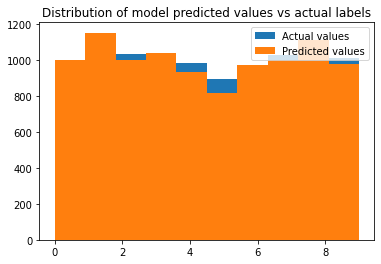

In [ ]:
_ = model_predictions(ann_noisy,X_test)

Predicted:  7


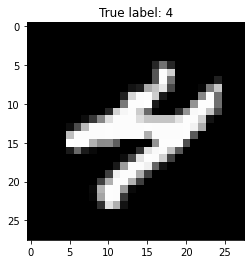

In [ ]:
i=show_mistake(ann_noisy,X_test)

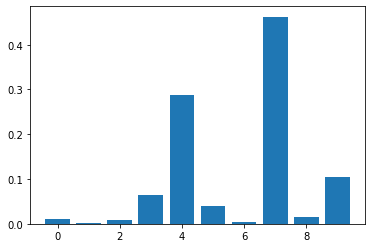

In [ ]:
confidence_distribution(ann_noisy, X_test,i)

Creating a __pure noise__ dataset made of random pixels

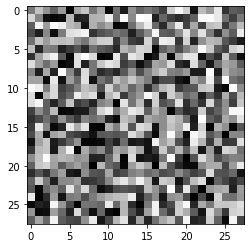

In [ ]:
noise = pd.DataFrame(np.random.rand(100, 784))
display(noise,None, 55)

#### ann_noisy is more like to label a pure noise data with high level of certainty 

In [ ]:
ind = 32
print("ann_noisy model's label guess and confidence on a pure noise image is ",confidence(ann_noisy.model, noise.iloc[ind,:]))
print("ann model's label guess and confidence on a pure noise image is ",confidence(ann.model, noise.iloc[ind,:]))

ann_noisy model's label guess and confidence on a pure noise image is  (8, 0.9446118)
ann model's label guess and confidence on a pure noise image is  (3, 0.9991881)


#### ann model is used to predict a set of noisy images. We find that a small number of them is labeled with very high confidence. It does not have high confidence in its predictions for noise data

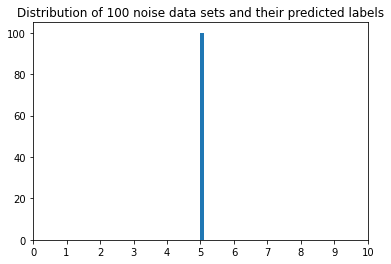

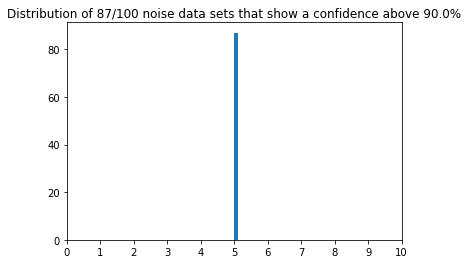

In [ ]:
noise_analysis(load('ann'),0.9)

#### ann_noisy model is used to predict a set of noisy images. We find that fewer of them are labeled with very high confidence

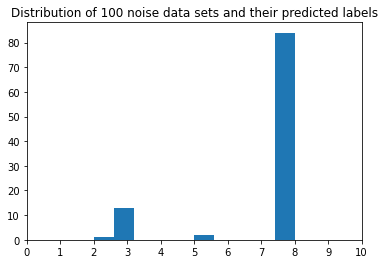

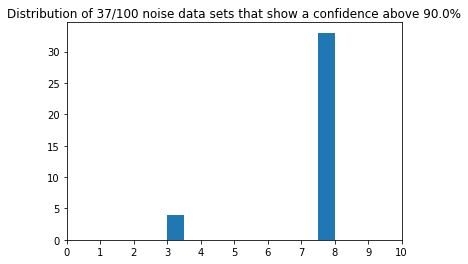

In [ ]:
noise_analysis(ann_noisy,0.9)

#### We append noise dataset to our original data and assign them to label:10

((65000, 784), (65000,))

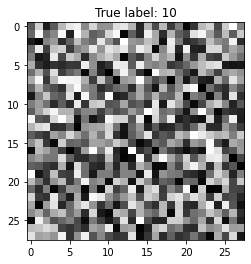

In [ ]:
noise = pd.DataFrame(np.random.rand(5000, 784))
X_train_plusnoisy = pd.concat([X_train, noise], axis=0)
y_min1 = pd.DataFrame(np.full((5000, ), 10))
y_train_plusnoisy = pd.concat([y_train, y_min1], axis=0)[0]
X_train_plusnoisy,y_train_plusnoisy = shuff_together(X_train_plusnoisy,y_train_plusnoisy)
display(X_train_plusnoisy,y_train_plusnoisy,y_train_plusnoisy[y_train_plusnoisy == 10].index[1])

noise = pd.DataFrame(np.random.rand(1000, 784))
X_test_plusnoisy = pd.concat([X_test, noise], axis=0)
y_min1 = pd.DataFrame(np.full((1000, ), 10))
y_test_plusnoisy = pd.concat([y_test, y_min1], axis=0)[0]
X_test_plusnoisy,y_test_plusnoisy = shuff_together(X_test_plusnoisy,y_test_plusnoisy)
X_train_plusnoisy.shape,y_train_plusnoisy.shape

#### We now train an ANN with pure noise set as a seperate input

INFO:tensorflow:Assets written to: ann_plusnoisey\assets


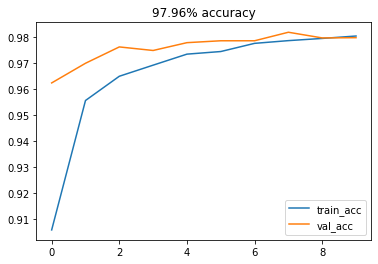

In [ ]:
features = X_train_plusnoisy.shape[1]

model = create_ann(11)
ann_plusnoisey = model.fit(X_train_plusnoisy, y_train_plusnoisy, validation_data=(X_test_plusnoisy, y_test_plusnoisy), epochs=10,verbose=0)
ann_plusnoisey.model.save("ann_plusnoisey")
model_stats(ann_plusnoisey)
#load("ann")

#### This classifies noise correctly

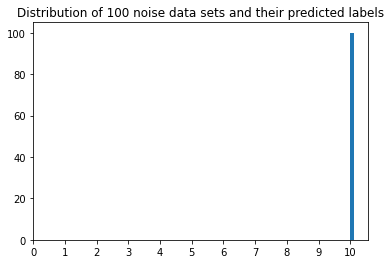

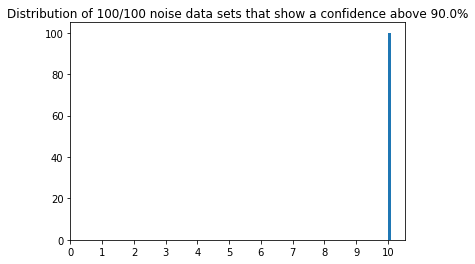

In [ ]:
noise_analysis(ann_plusnoisey,0.9)

#### We will create a training set that is noisy data plus noise

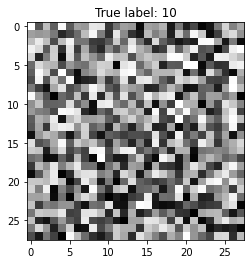

In [ ]:
noise = pd.DataFrame(np.random.rand(5000, 784))
X_trainnoisy_plusnoise = pd.concat([X_train_noisy, noise], axis=0)
y_min1 = pd.DataFrame(np.full((5000, ), 10))
y_trainnoisy_plusnoise = pd.concat([y_train, y_min1], axis=0)[0]
X_trainnoisy_plusnoise,y_trainnoisy_plusnoise = shuff_together(X_train_plusnoisy,y_train_plusnoisy)
display(X_trainnoisy_plusnoise,y_trainnoisy_plusnoise,y_trainnoisy_plusnoise[y_trainnoisy_plusnoise == 10].index[1])

#### We can create an ANN that is trained on noisy data and noise and it does a good job of labelling original data and noise correctly

INFO:tensorflow:Assets written to: ann_noisy_plusnoise\assets


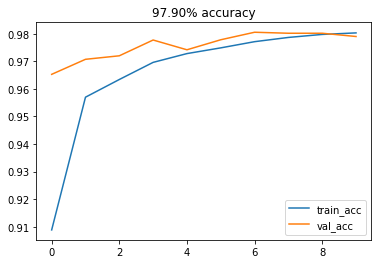

In [ ]:
features = X_trainnoisy_plusnoise.shape[1]

model = create_ann(11)
ann_noisy_plusnoise = model.fit(X_trainnoisy_plusnoise, y_trainnoisy_plusnoise, validation_data=(X_test_plusnoisy, y_test_plusnoisy), epochs=10,verbose=0)
ann_noisy_plusnoise.model.save("ann_noisy_plusnoise")
model_stats(ann_noisy_plusnoise)
#load("ann")

#### But it does a bad job of labelling noisy test data with most predictions being  5

In [ ]:
ann_noisy_plusnoise.model.evaluate(X_test_noisy,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 7.8381 - accuracy: 0.1930


[7.838090419769287, 0.19300000369548798]

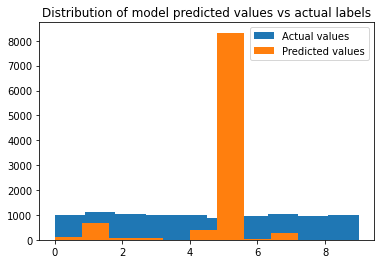

In [ ]:
_ = model_predictions(ann_noisy_plusnoise,X_test_noisy)

#### This also seem to show very high confidence in its incorrectly predicted labels.

Predicted:  5


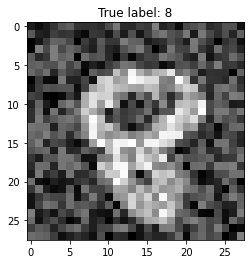

In [ ]:
i=show_mistake(ann_noisy_plusnoise,X_test_noisy)

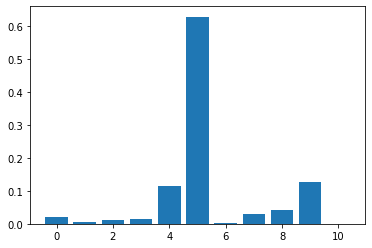

In [ ]:
confidence_distribution(ann_noisy_plusnoise, X_test_noisy,i,op=11)

#### What will happen if the model is faced with inverted data?

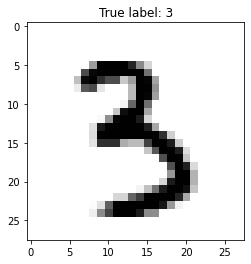

In [ ]:
inverted = X_test.apply(lambda x: 1-x)
display(inverted,y_test,ind)

#### Every thing is labelled as noise with high certainty

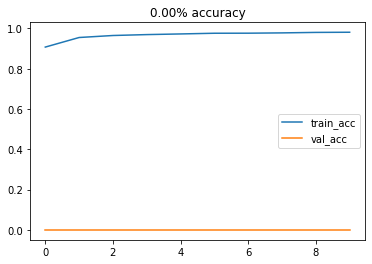

In [ ]:
model = create_ann(11)
r = model.fit(X_train_plusnoisy, y_train_plusnoisy, validation_data=(inverted, y_test), epochs=10,verbose=0)
#ann.model.save("ann")
model_stats(r)

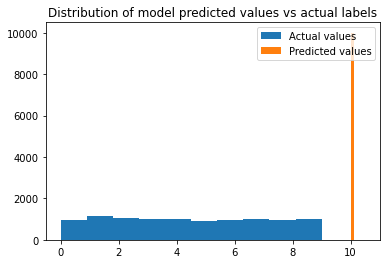

In [ ]:
_ = model_predictions(r,inverted)

Predicted:  10


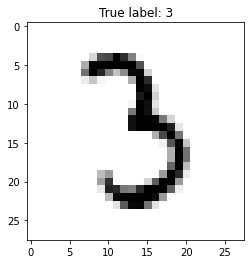

In [ ]:
i=show_mistake(r,inverted)

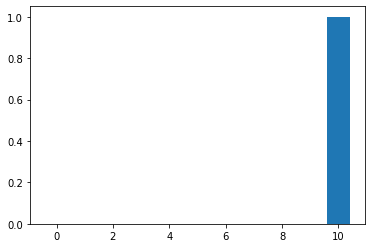

In [ ]:
confidence_distribution(r, inverted,i,11)

#### The original standard ANN without noise label predicted most inverted images as 5 with very high confidence

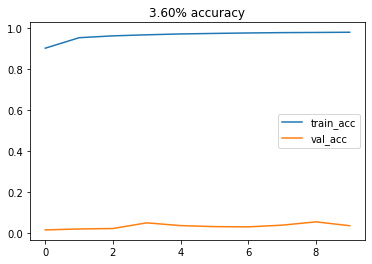

In [ ]:
model = create_ann()
r = model.fit(X_train, y_train, validation_data=(inverted, y_test), epochs=10,verbose=0)
#ann.model.save("ann")
model_stats(r)

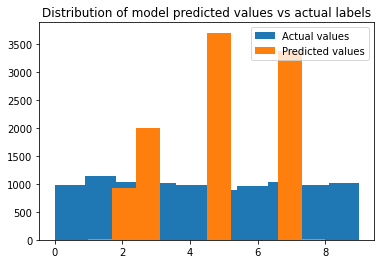

In [ ]:
_ = model_predictions(r,inverted)


Predicted:  5


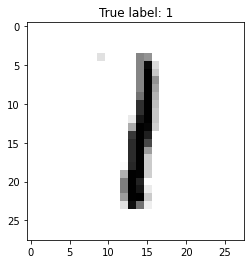

In [ ]:
i=show_mistake(r,inverted)

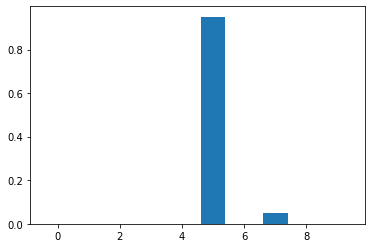

In [ ]:
confidence_distribution(r, inverted,i)

### We will now create a model based on RNN

In [ ]:
(X, y), (X_t, y_t) = mnist.load_data()
X, X_t = X / 255.0, X_t / 255.0

def create_rnn():
    i = Input(shape=X[0].shape)
    x = LSTM(128, return_sequences=True,dropout=0.2)(i)
    x = GlobalMaxPool1D()(x)
    x = Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(i, x)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def confidence(model, ip):
    try:
        model = model.model
    except:
        pass
    a=list(model.predict(np.expand_dims(ip, axis=0))[0])
    return a.index(max(a)),max(a)

def confidence_distribution(model, ip,ind = 0):
    try:
        model = model.model
    except:
        pass
    l=model.predict(ip.values.reshape(-1,1,28,28)[ind])[0]
    plt.bar([i for i in range(10)],l)
    plt.show()
    

def noise_analysis(model, conf_th = 0.75, noise_n = 100):
    noise = np.random.rand(noise_n, 28,28)
    nums=[]
    cnum=[]
    try:
        model = model.model
    except:
        pass
    for i in range(noise.shape[0]):
        num,conf = confidence(model, noise[i])
        nums.append(num)
        if conf>conf_th:
            cnum.append(num)
    plt.hist(nums)
    plt.xticks(range(11))
    plt.title("Distribution of "+str(len(nums))+" noise data sets and their predicted labels")
    plt.show()
    plt.hist(cnum)
    plt.xticks(range(11))
    plt.title("Distribution of "+str(len(cnum))+"/"+str(len(nums))+" noise data sets that show a confidence above "+str(conf_th*100)+"%")
    plt.show()
    
def show_mistake(model,df,i=None,y_test = y_test):
    try:
        model = model.model
    except:
        pass
    try:
        p_test = model.predict(df.values.reshape(-1,28,28)).argmax(axis=1)
    except:
        p_test = model.predict(df.argmax(axis=1))                           
    wrong_idx = np.where(p_test != y_test)[0]
    if i is None:
        i = np.random.choice(wrong_idx)
    display(df, y_test, i)
    print("Predicted: ",p_test[i])
    return i

def model_predictions(model,df,y_test=y_test):
    try:
        model = model.model
    except:
        pass
    try:
        preds = model.predict(df.values.reshape(-1,28,28)).argmax(axis=1)
    except:
        preds = model.predict(df.argmax(axis=1))
    plt.hist(y_test, label=['Actual values'])
    plt.hist(preds, label=['Predicted values'])
    plt.legend(loc='upper right')
    plt.title("Distribution of model predicted values vs actual labels")
    plt.show()
    return preds


#### We have high accuracy similar to ANN

Epoch 1/10
1875/1875 [==============================] - 26s 13ms/step - loss: 0.7777 - accuracy: 0.7581 - val_loss: 0.1553 - val_accuracy: 0.9539
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1461 - accuracy: 0.9564 - val_loss: 0.0827 - val_accuracy: 0.9754
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0957 - accuracy: 0.9714 - val_loss: 0.0633 - val_accuracy: 0.9823
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0762 - accuracy: 0.9774 - val_loss: 0.0492 - val_accuracy: 0.9844
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0612 - accuracy: 0.9812 - val_loss: 0.0549 - val_accuracy: 0.9830
Epoch 6/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0489 - accuracy: 0.9842 - val_loss: 0.0369 - val_accuracy: 0.9882
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0437 - accuracy: 0.9869 - val_loss: 0.0413 -

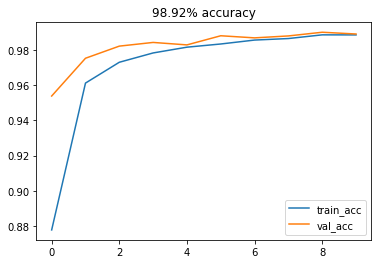

In [ ]:
model = create_rnn()
rnn = model.fit(X, y, validation_data=(X_t, y_t), epochs=10, verbose=1)
model_stats(rnn)

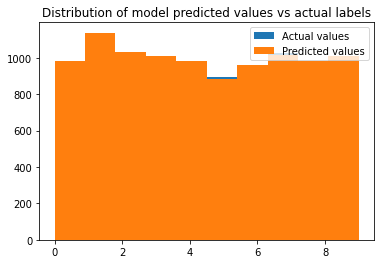

In [ ]:
_ = model_predictions(rnn,X_test)

Predicted:  2


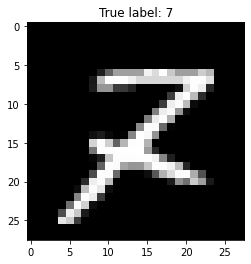

In [ ]:
i=show_mistake(rnn,X_test)

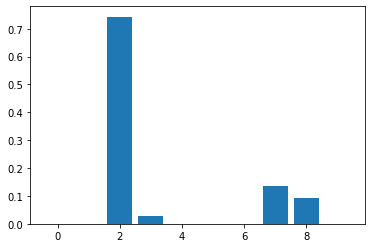

In [ ]:
confidence_distribution(rnn,X_test,i)

#### But its performance on noisy data is worse than ANN

In [ ]:
rnn.model.evaluate(X_test_noisy.values.reshape(-1,28,28), y_test)

313/313 [==============================] - 2s 5ms/step - loss: 5.4675 - accuracy: 0.1162


[5.467532157897949, 0.11620000004768372]

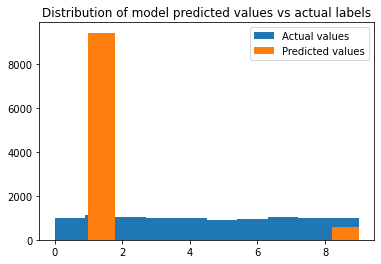

In [ ]:
_ = model_predictions(rnn,X_test_noisy)

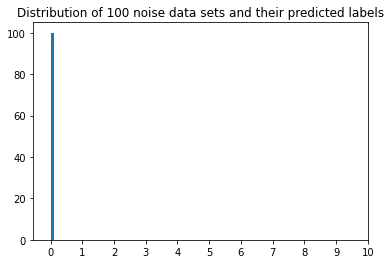

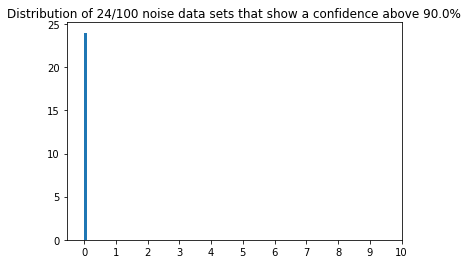

In [ ]:
noise_analysis(rnn,0.9)

In [ ]:
noise_28by28 = noise.values.reshape(-1,28,28)
noise_28by28.shape

(5000, 28, 28)

#### The rnn predicts each noise as almost entirely 0

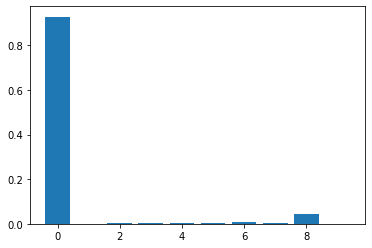

In [ ]:
confidence_distribution(rnn,noise,np.random.randint(150))

#### Training and validation using noisy data

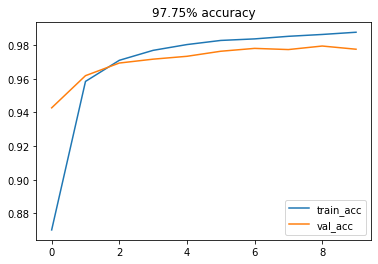

In [ ]:
model = create_rnn()
rnn_noisy = model.fit(X_train_noisy.values.reshape(-1,28,28), y_train, validation_data=(X_test_noisy.values.reshape(-1,28,28), y_test), epochs=10,verbose=0)
model_stats(rnn_noisy)

#### This model does not do well in predicting the standard test data, labelling most of them as certain 2 numbers

In [ ]:
rnn_noisy.model.evaluate(X_t, y_t)

313/313 [==============================] - 2s 5ms/step - loss: 1.5631 - accuracy: 0.5597


[1.563126564025879, 0.5597000122070312]

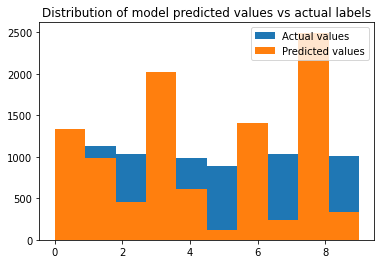

In [ ]:
_ = model_predictions(rnn_noisy,X_test)

Predicted:  3


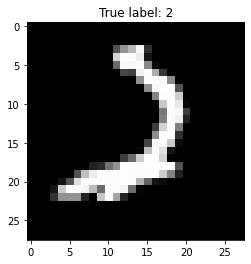

In [ ]:
i=show_mistake(rnn_noisy,X_test)

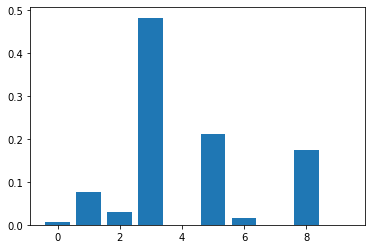

In [ ]:
confidence_distribution(rnn_noisy,X_test,i)

#### But it does seem to recognize pure noise well, not being confident about them

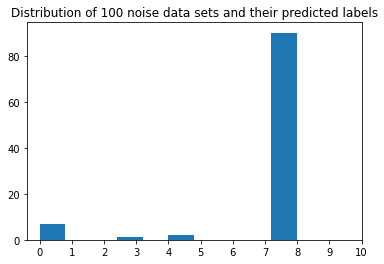

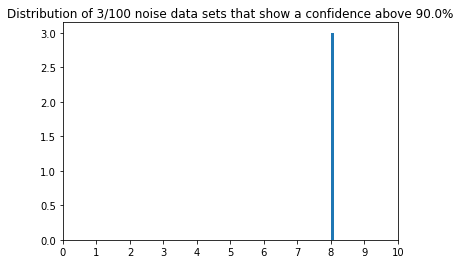

In [ ]:
noise_analysis(rnn_noisy,0.9)

#### confidence_distribution of random noise data

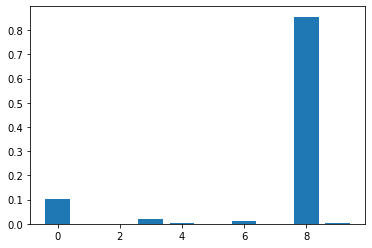

In [ ]:
confidence_distribution(rnn_noisy,noise,np.random.randint(150))

#### As expected, it does poorly with inverted data

In [ ]:
rnn_noisy.model.evaluate(inverted.values.reshape(-1,28,28), y_t)

313/313 [==============================] - 2s 5ms/step - loss: 5.9361 - accuracy: 0.0936


[5.9360527992248535, 0.09359999746084213]

#### The Intelligence seems to be comparable to the others

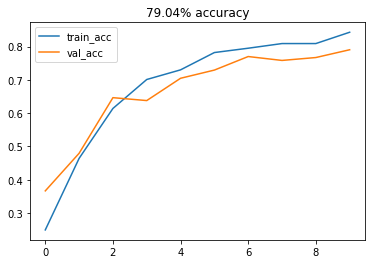

In [ ]:
model = create_rnn()
rnn = model.fit(X[:maxrows,:,:], y[:maxrows,], validation_data=(X_test.values.reshape(-1,28,28), y_test), epochs=10,verbose=0)
model_stats(rnn)

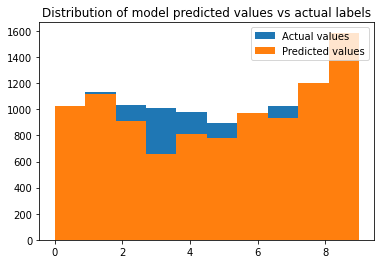

In [ ]:
_ = model_predictions(rnn,X_test)

#### The Intelligence of threshold trained model set seems to be similar

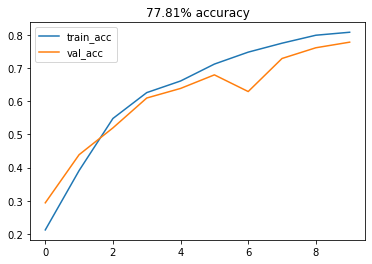

In [ ]:
model = create_rnn()
rnn = model.fit(X_train_50[:maxrows].values.reshape(-1,28,28), y[:maxrows,], validation_data=(X_test_50.values.reshape(-1,28,28), y_test), epochs=10,verbose=0)
model_stats(rnn)

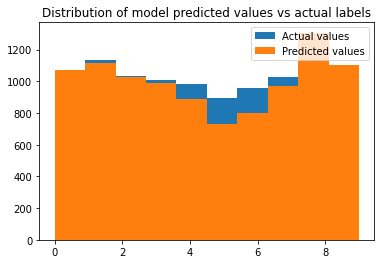

In [ ]:
_ = model_predictions(rnn,X_test_50)

### We will now create a model based on CNN

In [21]:
(X, y), (X_t, y_t) = mnist.load_data()

def create_cnn(op=10):
        model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(op, activation='softmax')])
        model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        return model

def model_stats(model):
    a_float = model.history.history['val_accuracy'][-1]*100
    plt.plot(model.history.history['accuracy'], label='train_acc')
    plt.plot(model.history.history['val_accuracy'], label='val_acc')
    plt.title("{:.2f}".format(a_float)+"% accuracy")
    plt.legend()
    
def model_predictions(model,df,y_test=y_test):
    try:
        model = model.model
    except:
        pass
    #preds = model.predict(df)
    try:
        l=model.predict(df).argmax(axis=1)
    except:
        l=model.predict(df.values.reshape(-1,28, 28,1)).argmax(axis=1)
    #l=[list(preds[i]).index(max(preds[i])) for i in range(preds.shape[0])]
    plt.hist(y_test, label=['Actual values'])
    plt.hist(l, label=['Predicted values'])
    plt.legend(loc='upper right')
    plt.title("Distribution of model predicted values vs actual labels")
    plt.show()
    return l

def show_mistake(model,df,i=None,y_test = y_test):
    try:
        model = model.model
    except:
        pass
    try:
        p_test=model.predict(df).argmax(axis=1)
    except:
        p_test=model.predict(df.values.reshape(-1,28, 28,1)).argmax(axis=1)
    #p_test = model.predict(df).argmax(axis=1)
    wrong_idx = np.where(p_test != y_test)[0]
    if i is None:
        i = np.random.choice(wrong_idx)
    display(df, y_test, i)
    print("Predicted: ",p_test[i])
    return i

def confidence_distribution(model, df,ind = 0,op=10):
    try:
        model = model.model
    except:
        pass
    try:
        l=model.predict(df[ind])[0]
    except:
        ip = df.values.reshape(-1,28, 28,1)
        l=model.predict(ip[ind].reshape(-1,28, 28,1))[0]
    plt.bar([i for i in range(op)],l)
    plt.show()
    

def confidence(model, ip, label=None):
    try:
        model = model.model
    except:
        pass
    #a=model.predict(ip)[0]
    try:
        a=model.predict(ip)[0]
    except:
        ip = ip.values.reshape(-1,28, 28,1)
        a=model.predict(ip.reshape(-1,28, 28,1))[0]
    #v= ip.values
    #v=v.reshape(-1,1)
    a=list(a)
    if not label:
      return a.index(max(a)),max(a)      
    return a[label]

    
def noise_analysis(model, conf_th = 0.75, noise_n = 100):
    #noise = pd.DataFrame(np.random.rand(noise_n, 784))
    noise = np.random.rand(100, 1,28,28,1)
    nums=[]
    cnum=[]
    try:
        model = model.model
    except:
        pass
    for i in range(noise.shape[0]):
        num,conf = confidence(model, noise[i])
        nums.append(num)
        if conf>conf_th:
            cnum.append(num)
    plt.hist(nums)
    plt.xticks(range(11))
    plt.title("Distribution of "+str(len(nums))+" noise data sets and their predicted labels")
    plt.show()
    plt.hist(cnum)
    plt.xticks(range(11))
    plt.title("Distribution of "+str(len(cnum))+"/"+str(len(nums))+" noise data sets that show a confidence above "+str(conf_th*100)+"%")
    plt.show()

#### Each data point accepted by the CNN must be 3 dimensional

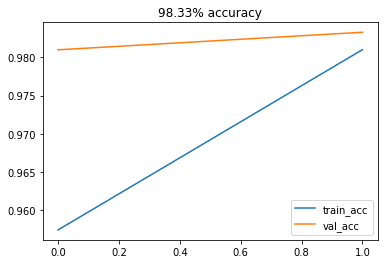

In [ ]:
cnn = create_cnn()
#X = X.reshape(-1,28, 28,1)
#X_t = X_t.reshape(-1,28, 28,1)
cnn.fit(np.array(X_train).reshape(-1,28, 28,1), y, epochs=2, validation_data=(np.array(X_test).reshape(-1,28, 28,1), y_t), verbose=0)

model_stats(cnn)

Predicted:  8


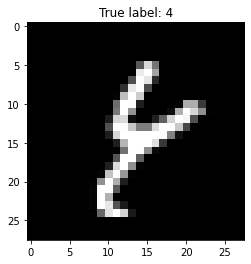

In [ ]:
i=show_mistake(cnn,X_test)

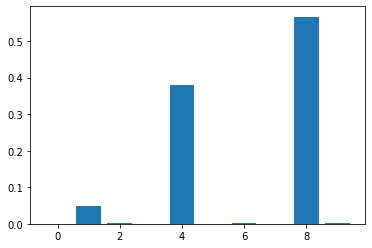

In [ ]:
confidence_distribution(cnn, X_test,i)

#### Intelligence


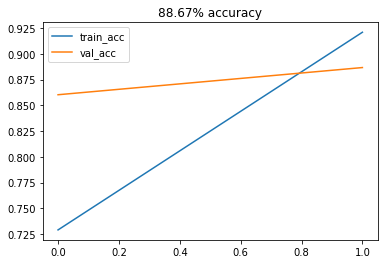

In [22]:
maxrows = 1000

cnn = create_cnn()
cnn.fit(np.array(X_train).reshape(-1,28, 28,1)[:maxrows,:,:], y[:maxrows], epochs=2, validation_data=(np.array(X_test).reshape(-1,28, 28,1), y_t), verbose=0)
model_stats(cnn)

#### Trying to see if this CNN model works on noisy data, results appear worse than for ANN, with most predictions showing 1,7

In [ ]:
cnn.evaluate(np.array(X_test_noisy).reshape(-1,28, 28,1),y_t)

313/313 [==============================] - 4s 12ms/step - loss: 68.1384 - accuracy: 0.2126


[68.13839721679688, 0.2125999927520752]

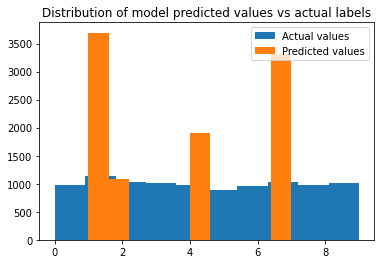

In [ ]:
_ = model_predictions(cnn,X_test_noisy)

#### This is how it views pure noise data

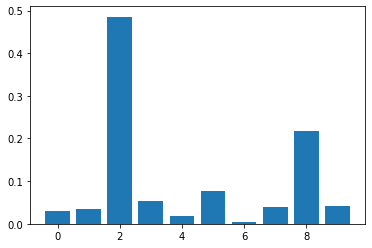

In [ ]:
noise = np.random.rand(100, 1,28,28,1)
confidence_distribution(cnn, noise,10)

#### It does seem to recognize pure noise well, not being confident about them

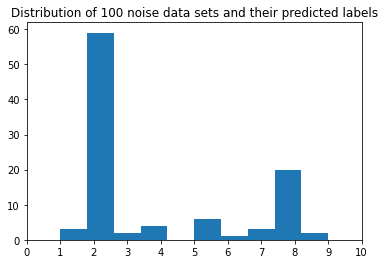

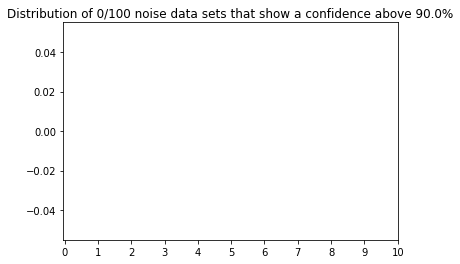

In [ ]:
noise_analysis(cnn,0.9)

#### We see much better results when faced with inverted test data

In [ ]:
cnn.evaluate(np.array(inverted).reshape(-1,28, 28,1),y_t)

313/313 [==============================] - 4s 12ms/step - loss: 1.2094 - accuracy: 0.6287


[1.2093627452850342, 0.6287000179290771]

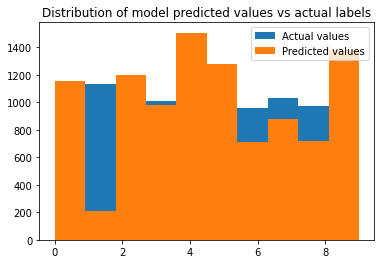

In [ ]:
_ = model_predictions(cnn,inverted)

#### Training CNN using noisy train data

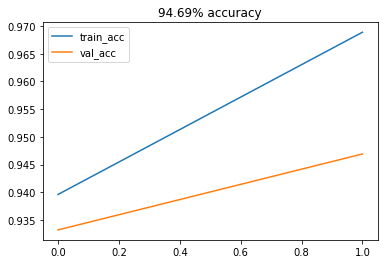

In [ ]:
cnn = create_cnn()
cnn.fit(np.array(X_train_noisy).reshape(-1,28, 28,1), y, epochs=2, validation_data=(np.array(X_test_noisy).reshape(-1,28, 28,1), y_t), verbose=0)
model_stats(cnn)

#### When trained on noisy data, CNN gives above 90% accuracy for both noisy and original test data

In [ ]:
cnn.evaluate(np.array(X_test).reshape(-1,28, 28,1),y_t)

313/313 [==============================] - 4s 12ms/step - loss: 0.2029 - accuracy: 0.9351


[0.20290842652320862, 0.9351000189781189]

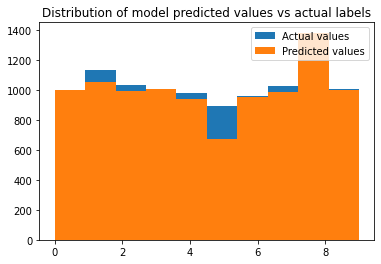

In [ ]:
_ = model_predictions(cnn,X_test)

#### But gives worse perfomance on inverted test data

In [ ]:
cnn.evaluate(np.array(inverted).reshape(-1,28, 28,1),y_t)

313/313 [==============================] - 4s 12ms/step - loss: 5.8447 - accuracy: 0.3773


[5.844680309295654, 0.3772999942302704]

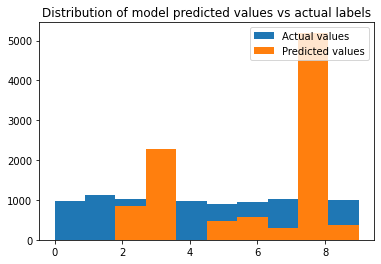

In [ ]:
_ = model_predictions(cnn,np.array(inverted).reshape(-1,28, 28,1))